## Figure 3: Compare Cellpose and MicroSAM variants on a single image

Run three segmenters on the same image and show the original (top) and overlays (bottom):
- CellposeSegmenter
- MicroSamSegmenter
- MicroSamYoloSegmenter (if available, otherwise a MicroSam fallback)

Image: `data/addhopin blood cells/subset/BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg`

In [3]:
import os
from pathlib import Path
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import mask_overlay

# Import segmenter wrappers directly (let errors surface if unavailable)
from napari_ai_lab.Segmenters.GlobalSegmenters import CellposeSegmenter, MicroSamSegmenter, MicroSamYoloSegmenter

# Path to the single image to analyze (relative to this notebook)
image_path = Path('../../reproducible-dl-seg-article/data/addhopin blood cells/subset/BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg')
print('Image:', image_path)
img = io.imread(str(image_path))
# Ensure RGB
if img.ndim == 2:
    img = np.expand_dims(img, axis=2)
    img = np.repeat(img, 3, axis=2)
print('Loaded image shape:', img.shape)

# Helper: short name for plotting titles
import os as _os
def short_name(p):
    base = _os.path.basename(str(p))
    idx = base.lower().find('jpg')
    return base[:idx+3] if idx != -1 else base

# Holders for results
segmenter_names = []
masks = []
overlays = []

# Cellpose
cps = CellposeSegmenter(model_type='cyto2', diameter=None)
print('Created CellposeSegmenter')
seg_cp = cps.segment(img)
segmenter_names.append('CellposeSegmenter')
masks.append(seg_cp)
overlays.append(mask_overlay(img, seg_cp))

# MicroSAM
ms = MicroSamSegmenter()
print('Created MicroSamSegmenter')
seg_ms = ms.segment(img)
segmenter_names.append('MicroSamSegmenter')
masks.append(seg_ms)
overlays.append(mask_overlay(img, seg_ms))

# MicroSAM-YOLO
my = MicroSamYoloSegmenter(conf=0.1, imgsz=1024, max_area=40000)
print('Created MicroSamYoloSegmenter')
seg_my = my.segment(img)
segmenter_names.append('MicroSamYoloSegmenter')
masks.append(seg_my)
overlays.append(mask_overlay(img, seg_my))

model_type argument is not used in v4.0.1+. Ignoring this argument...


Image: ..\..\reproducible-dl-seg-article\data\addhopin blood cells\subset\BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg
Loaded image shape: (416, 416, 3)
Created CellposeSegmenter
Created MicroSamSegmenter
MicroSam: Using device: cuda
MicroSam: Using non-tiled segmentation
MicroSam: Loading model type: vit_b_lm
MicroSam: Running segmentation (ndim=2)...


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


MicroSam: Found 1 instances
Created MicroSamYoloSegmenter
Predicting bounding boxes for image data



0: 1024x1024 24 objects, 44.0ms
Speed: 8.1ms preprocess, 44.0ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)
Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


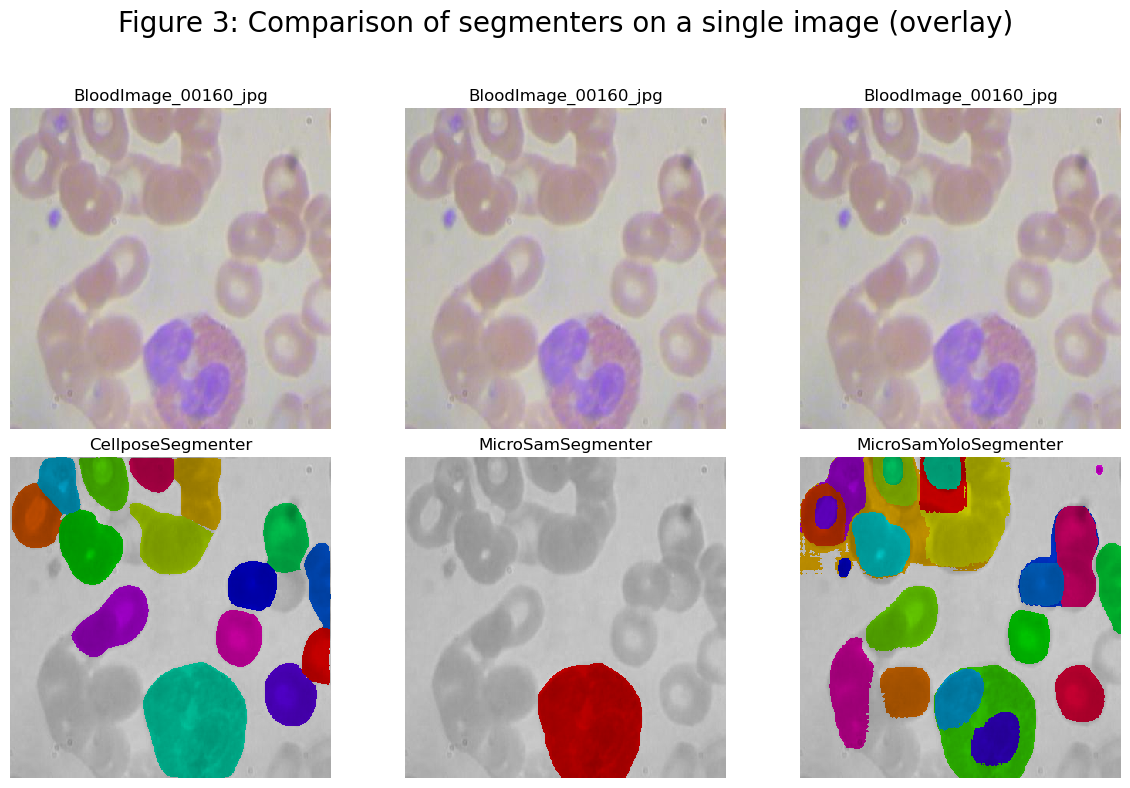

In [4]:
# Plot original (top) and overlays (bottom) side-by-side
n = len(overlays)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
# Top: original repeated
for i in range(n):
    axes[0, i].imshow(img)
    axes[0, i].set_title(short_name(image_path))
    axes[0, i].axis('off')
# Bottom: overlays from each segmenter
for i in range(n):
    axes[1, i].imshow(overlays[i])
    axes[1, i].set_title(segmenter_names[i])
    axes[1, i].axis('off')
plt.suptitle('Figure 3: Comparison of segmenters on a single image (overlay)', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Figure 3 caption
Comparison of three segmentation approaches applied to the same sample from the addhopin blood cells subset. Top row: original RGB image. Bottom row (left-to-right): Cellpose predicted instance overlay, MicroSAM predicted instance overlay, and MicroSAM-YOLO (or fallback) predicted instance overlay. All methods were run with their default parameters; colors indicate distinct instances in the overlays. If a wrapper is unavailable in the running environment, a placeholder was used and the cell prints a note explaining the fallback.

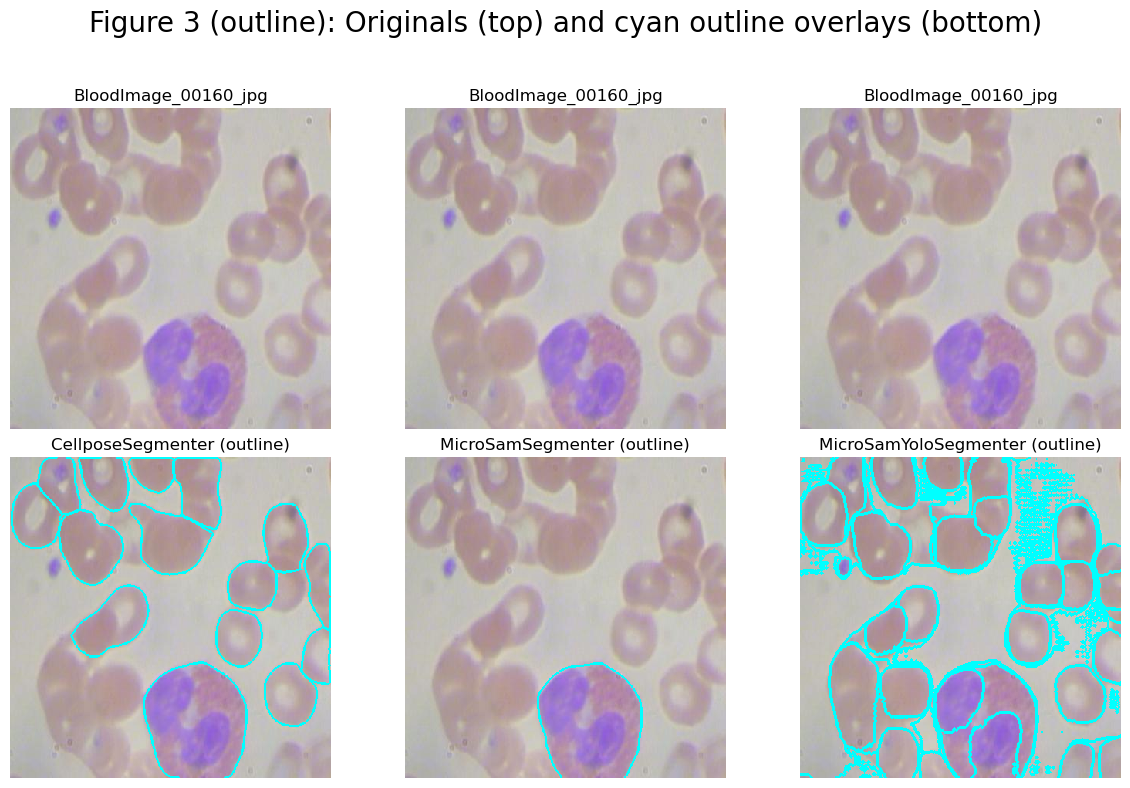

In [16]:
# Create outline overlays (cyan) and display originals + outlines
from skimage.segmentation import find_boundaries
from scipy import ndimage as ndi

# Ensure images are RGB
def ensure_three_channels_local(img):
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
        img = np.repeat(img, 3, axis=2)
    return img

outline_overlays = []
for mask, im in zip(masks, [img]*len(masks)):
    im_rgb = ensure_three_channels_local(im)
    boundaries = find_boundaries(mask, mode='inner')
    boundaries = ndi.binary_dilation(boundaries, iterations=1)
    overlay = im_rgb.copy()
    # cyan outline (R,G,B)
    overlay[boundaries] = (0, 255, 255)
    outline_overlays.append(overlay)

# Plot originals and outlines
n = len(outline_overlays)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
for i in range(n):
    axes[0, i].imshow(img)
    axes[0, i].set_title(short_name(image_path))
    axes[0, i].axis('off')
    axes[1, i].imshow(outline_overlays[i])
    axes[1, i].set_title(segmenter_names[i] + ' (outline)')
    axes[1, i].axis('off')

plt.suptitle('Figure 3 (outline): Originals (top) and cyan outline overlays (bottom)', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()